# Import Dependencies


In [ ]:
!pip install keras==3.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.10.0
    Uninstalling keras-3.10.0:
      Successfully uninstalled keras-3.10.0


In [ ]:
!pip install tensorflow




## **Application and Goal: Automated Lyric Content Moderation**

### **Introduction & Motivation**
Given the exponential growth of music streaming platforms and user playlists, there is a pressing need to protect younger audiences from inappropriate or explicit lyrics. We can use machine learning algorithms to automate the classification of age appropriate song lyrics.[1][2]

***

### **Problem Statement in Context**
Our project develops and benchmarks text classification models to automatically identify explicit or age inappropriate lyrics. These classifiers can create safe and family friendly playlists, allow for quick review, and real time filtering of new song releases.[3][4]

***

### **Workflow and Research Contribution**
- **Data Pipeline:** We collected song lyric data and applied NLP preprocessing to ensure consistent quality and accurate text representation.
- **Model Training:** Multiple algorithms such as Logistic Regression, Random Forest, SVM, XGBoost are trained and compared on the labeled dataset.
- **Evaluation:** We systematically compared model generalization and robustness using standard metrics and identifying strengths
- **Interpretation:** Feature importance and error analysis identifies patterns and keywords most notable of determining the explicitness of a song.


1. Data loading & Inspection

In [ ]:
# Import libraries
import pandas as pd

# Load and preview the data
df = pd.read_csv('finalCombinedPlaylist.csv')
print(df.head())


            Artist                                          TrackName  \
0  Steven Universe  Let Us Adore You (feat. Christine Ebersole, Li...   
1      6arelyhuman                                 Hands up! - Slowed   
2           Cassie                                      Long Way 2 Go   
3  Backstreet Boys                             As Long as You Love Me   
4          Cardi B                                                 Up   

                                              Lyrics  AgeAppropriate  
0  Come live with us in the Palace Theres a room ...               1  
1  6arelyhuman Hey scene slut, Im still cutting t...               0  
2  I love it when they try to get intimate Even t...               0  
3  As long as you love me Although loneliness has...               1  
4  Up, up, up Ayy, up Uh, up, look This is fire O...               0  


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


2. Data loading & Inspection: Clean and lemmatize lyrics using spaCy. This removes noise and improves model performance.


In [ ]:
import spacy

# Initialize SpaCy English model
nlp = spacy.load('en_core_web_sm')

def preprocess_text(text):
    if pd.isna(text):
        return ""
    doc = nlp(str(text).lower())
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    return " ".join(tokens)

# Apply preprocessing to lyrics
df['clean_lyrics'] = df['Lyrics'].apply(preprocess_text)


3. Feature Engineering: Convert the cleaned lyrics to TF-IDF vectors for machine learning readiness. No valence feature needed.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2), stop_words='english')
X = tfidf.fit_transform(df['clean_lyrics'])
y = df['AgeAppropriate']  # Target label


4. Train-Test Split
Split the dataset into train and test sets, preserving the balance of age appropriateness.



In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

Using LSTM as another form of processing the lyrics as a sequence of words, capturing word order and context, which is lost when using TF-IDF.

We are going to need for all the models

In [ ]:
# Saving all the results

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import sys
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, auc, precision_recall_curve, PrecisionRecallDisplay
import matplotlib.pyplot as plt

def create_graphics(y_true, y_pred, y_proba, directory_name="model"):
    dir_path = os.path.join("results", directory_name)
    # dir_path = os.path.join("drive", "MyDrive", "results", directory_name)
    os.makedirs(dir_path, exist_ok=True)
    cm_train = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                                display_labels=["Not Kids", "Kids"])

    fpr, tpr, thresholds = roc_curve(y_true, y_proba, pos_label=1)

    disp.plot()
    disp.figure_.savefig(os.path.join(dir_path, f"{directory_name}_confusion_matrix.png"))

    roc_auc = auc(fpr, tpr)
    disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    disp.plot()
    disp.figure_.savefig(os.path.join(dir_path,f"{directory_name}_roc_curve.png"))


    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    disp.figure_.savefig(os.path.join(dir_path, f"{directory_name}_precision_recall_curve.png"))

    # now to plot the probability distribution, had to use matplot lib because,
    # sklearn doesn't have something for this
    plt.figure(figsize=(15,7))
    plt.hist(y_proba[y_true==0], bins=50, label='Not Kids')
    plt.hist(y_proba[y_true==1], bins=50, label='Kids', alpha=0.7, color='r')
    plt.xlabel('Probability of being Positive Class', fontsize=25)
    plt.ylabel('Count', fontsize=25)
    plt.legend(fontsize=15)
    plt.tick_params(axis='both', labelsize=25, pad=5)
    plt.savefig(os.path.join(dir_path,f"{directory_name}_probability_distribution.png"))


    # Now write the reports
    with open(os.path.join(dir_path, f"{directory_name}_classification_report.txt"), "w") as f:
        report = classification_report(y_true, y_pred, zero_division=0)
        print(report)
        f.write(report)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, TextVectorization, Bidirectional
from tensorflow.keras.models import Sequential
import pandas as pd

X_text = df['clean_lyrics']
y_text = df['AgeAppropriate']  # Target label
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y)

MAX_SEQUENCE_LENGTH = 40  # Pad all lyric sequences to 50 words
EMBEDDING_DIM = 20        # The size of the dense vector for each word
MAX_WORDS = 1000          # Max number of unique words to keep in the vocabulary

vectorize_layer = TextVectorization(
    max_tokens=MAX_WORDS,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH
)

# Adapt (Fit) the layer to your training data (the cleaned strings)
# This builds the vocabulary
print("Building vocabulary using TextVectorization...")
vectorize_layer.adapt(X_train_text.to_list())
vocab_size = len(vectorize_layer.get_vocabulary())
print(f"Vocabulary Size: {vocab_size}")

Building vocabulary using TextVectorization...
Vocabulary Size: 1000


5. Model Training and Evaluation

* a. LSTM

In [ ]:
import numpy as np
import keras
from sklearn.model_selection import KFold

model_lstm_native = Sequential()

# Input Layer: Accepts a string (raw text)
model_lstm_native.add(tf.keras.Input(shape=(1,), dtype=tf.string))

# 1. Text Vectorization Layer: Tokenizes and Pads the strings
model_lstm_native.add(vectorize_layer)

# 2. Embedding Layer: Converts word IDs to dense vectors
model_lstm_native.add(Embedding(input_dim=vocab_size,
                                 output_dim=EMBEDDING_DIM,
                                 mask_zero=True))

# 3. LSTM Layer: Processes the sequence
model_lstm_native.add(Bidirectional(LSTM(
    3,
    recurrent_dropout=0.2,
    kernel_regularizer=tf.keras.regularizers.l2(0.1)
)))
model_lstm_native.add(Dropout(0.3))

# 4. Dense Output Layers
model_lstm_native.add(Dense(1, activation='sigmoid'))

# Compile
model_lstm_native.compile(optimizer=keras.optimizers.Adam(learning_rate=0.1),
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

model_lstm_native.build(input_shape=(None, 1))

model_lstm_native.summary()

# Training
print("\nStarting LSTM Model Training...")

BATCH_SIZE = 64

kf = KFold(n_splits=5, shuffle=True, random_state=18)
for fold, (train_index, val_index) in enumerate(kf.split(X_train_text.to_list())):
    print("Currently on fold: ", fold)

    X_train_fold, X_val_fold = X_train_text.iloc[train_index], X_train_text.iloc[val_index]
    y_train_fold, y_val_fold = y_train_text.iloc[train_index], y_train_text.iloc[val_index]

    # 2. Convert the fold data into TensorFlow Datasets
    train_dataset = tf.data.Dataset.from_tensor_slices(
        (X_train_fold, y_train_fold)
    ).shuffle(10000).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)


    val_dataset = tf.data.Dataset.from_tensor_slices((X_val_fold, y_val_fold)
    ).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

    history_lstm = model_lstm_native.fit(
    train_dataset,
    epochs=2,
    validation_data=val_dataset,
    verbose=1
    )


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (None, 40)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_23 (Embedding)        │ (None, 40, 20)         │        20,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_23                │ (None, 6)              │           576 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,583 (80.40 KB)

 Trainable params: 20,583 (80.40 KB)

 Non-trainable params: 0 (0.00 B)


Starting LSTM Model Training...
Currently on fold:  0
Epoch 1/2
33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 0.5815 - loss: 1.4378 - val_accuracy: 0.5958 - val_loss: 0.7666
Epoch 2/2
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.6100 - loss: 0.7336 - val_accuracy: 0.6850 - val_loss: 1.0571
Currently on fold:  1
Epoch 1/2
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.6298 - loss: 0.9405 - val_accuracy: 0.6110 - val_loss: 0.7634
Epoch 2/2
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.6675 - loss: 0.7260 - val_accuracy: 0.6926 - val_loss: 0.7060
Currently on fold:  2
Epoch 1/2
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.6427 - loss: 0.8312 - val_accuracy: 0.6528 - val_loss: 0.7106
Epoch 2/2
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.6754 - loss: 0.7612 - val_accuracy: 0.6395 - val_loss: 0.9823
Currently on fold:  3
Epoch 1/2
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.6402 - loss: 0.9428 - val_accuracy: 0.6863 - val_loss: 2.

In [ ]:
from sklearn.metrics import classification_report
print("\nLSTM Model Training Complete. Evaluating...")

# Evaluate and print the classification report
print("\n--- LSTM Model Classification Report ---")

y_proba_lstm_train = model_lstm_native.predict(tf.constant(X_train_text.to_list(), dtype=tf.string))
y_proba_lstm_test = model_lstm_native.predict(tf.constant(X_test_text.to_list(), dtype=tf.string))

y_pred_lstm_train = (y_proba_lstm_train > 0.6).astype("int32").flatten()
y_pred_lstm_test = (y_proba_lstm_test > 0.6).astype("int32").flatten()


LSTM Model Training Complete. Evaluating...

--- Final LSTM Model Classification Report ---
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


              precision    recall  f1-score   support

           0       0.83      0.72      0.77      1116
           1       0.81      0.89      0.85      1517

    accuracy                           0.82      2633
   macro avg       0.82      0.81      0.81      2633
weighted avg       0.82      0.82      0.82      2633

              precision    recall  f1-score   support

           0       0.74      0.67      0.71       279
           1       0.78      0.83      0.80       380

    accuracy                           0.76       659
   macro avg       0.76      0.75      0.75       659
weighted avg       0.76      0.76      0.76       659



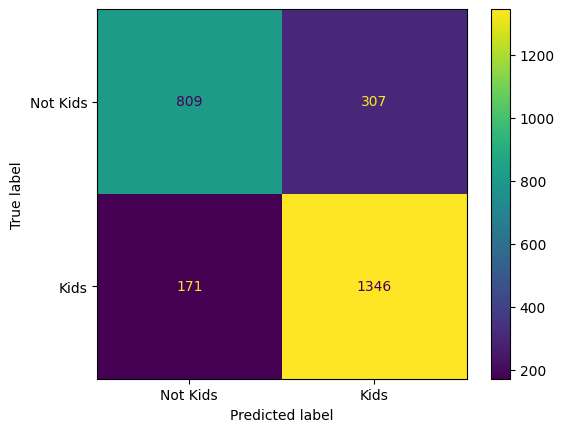

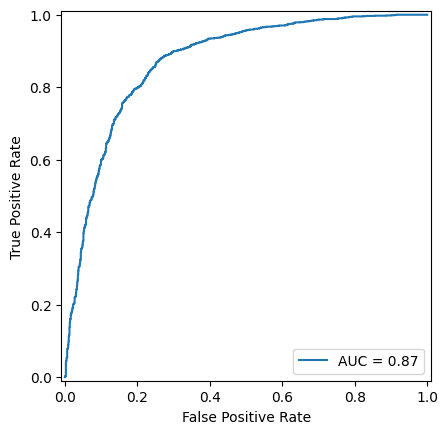

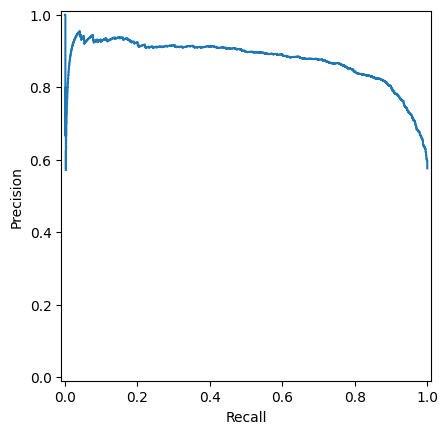

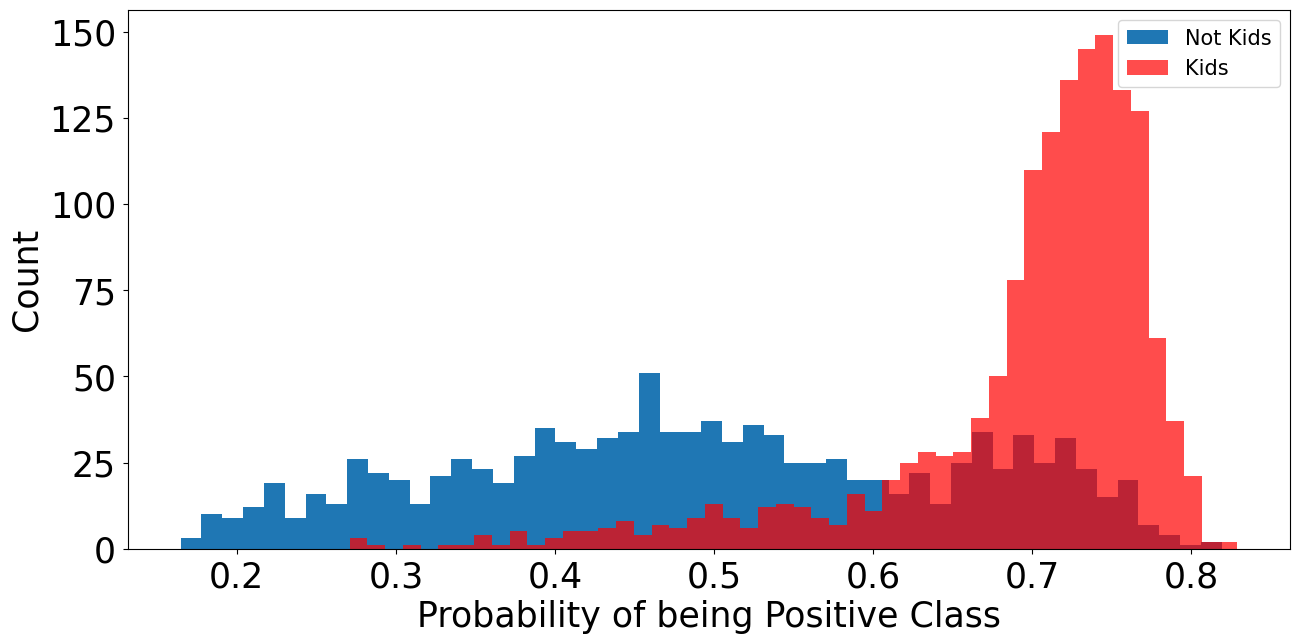

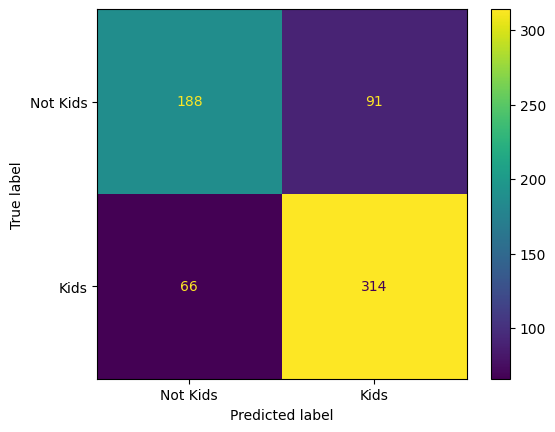

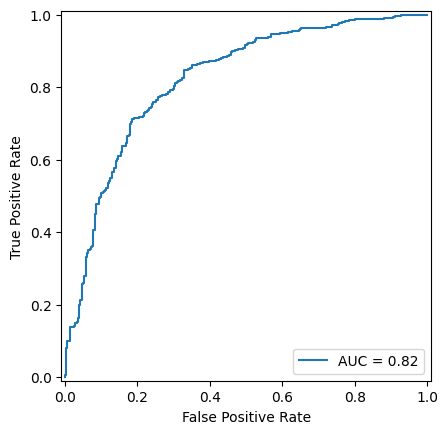

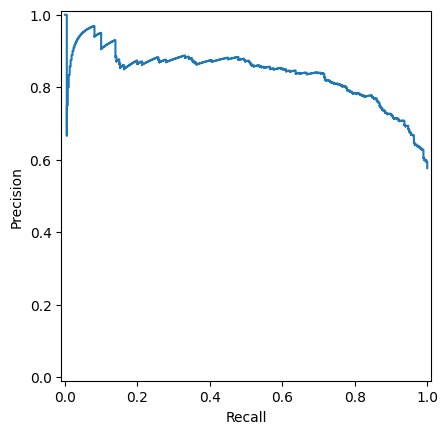

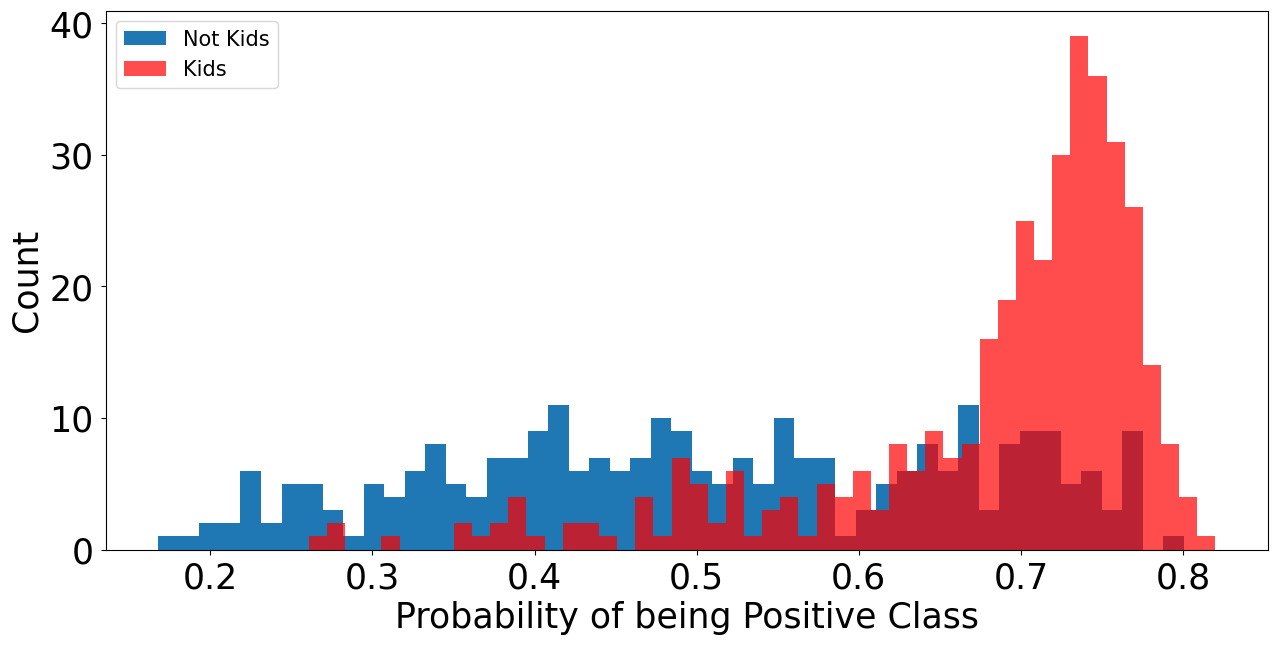

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, auc, precision_recall_curve, PrecisionRecallDisplay
import matplotlib.pyplot as plt
Y_train_int = y_train_text.values.astype("int32")
Y_test_int = y_test_text.values.astype("int32")

create_graphics(y_true=y_train_text, y_pred=y_pred_lstm_train, y_proba=y_proba_lstm_train, directory_name="lstm_train")
create_graphics(y_true=y_test_text, y_pred=y_pred_lstm_test, y_proba=y_proba_lstm_test, directory_name="lstm_test")



* b. Logistic Regression

Training Logistic Regression...
              precision    recall  f1-score   support

           0       0.96      0.77      0.86       976
           1       0.85      0.98      0.91      1328

    accuracy                           0.89      2304
   macro avg       0.91      0.87      0.88      2304
weighted avg       0.90      0.89      0.89      2304

              precision    recall  f1-score   support

           0       0.92      0.61      0.73       419
           1       0.77      0.96      0.86       569

    accuracy                           0.81       988
   macro avg       0.85      0.79      0.79       988
weighted avg       0.84      0.81      0.80       988



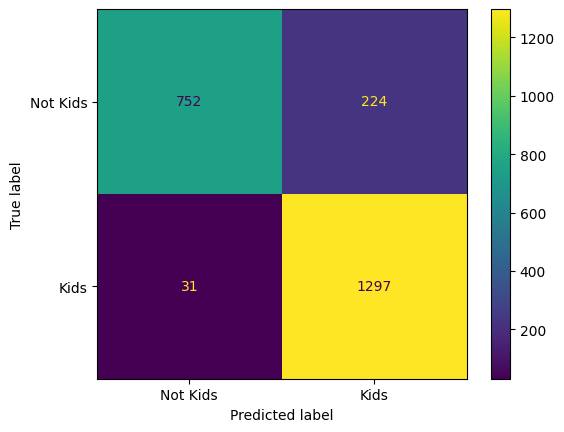

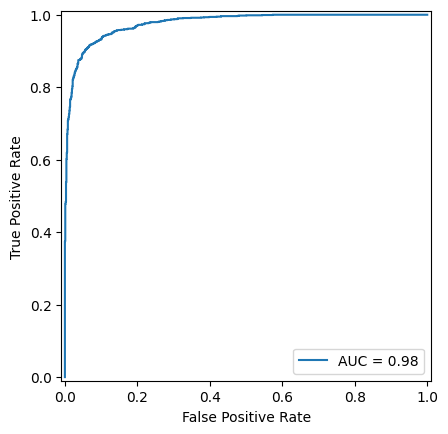

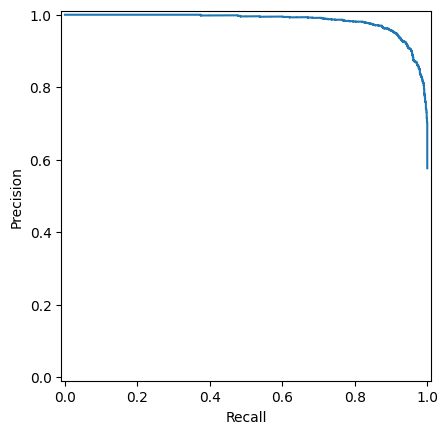

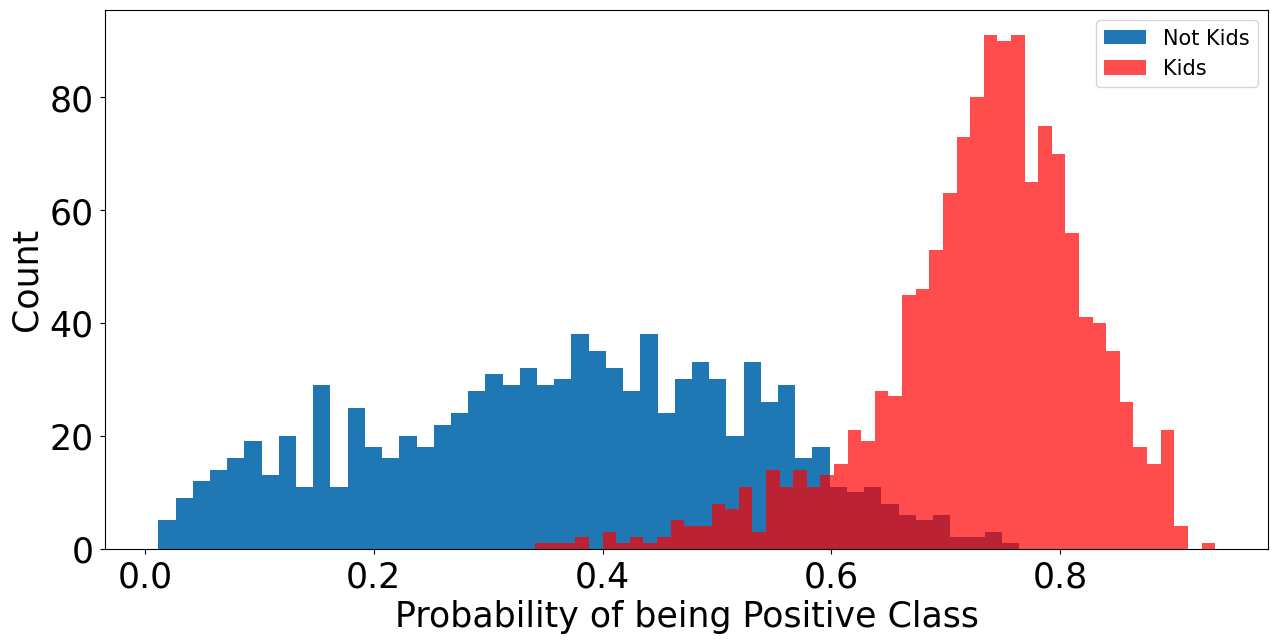

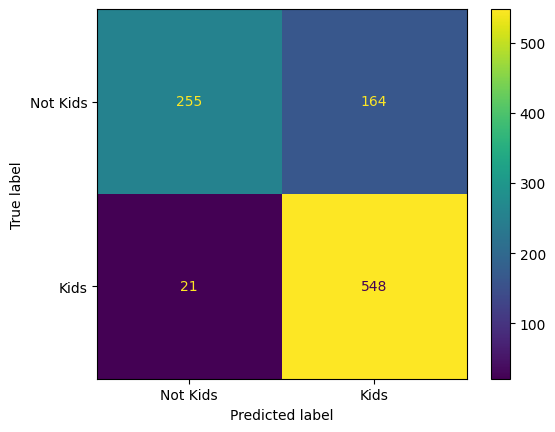

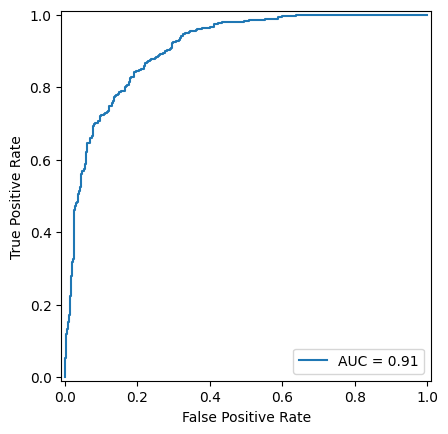

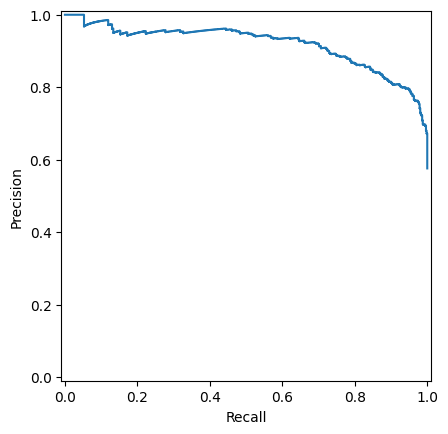

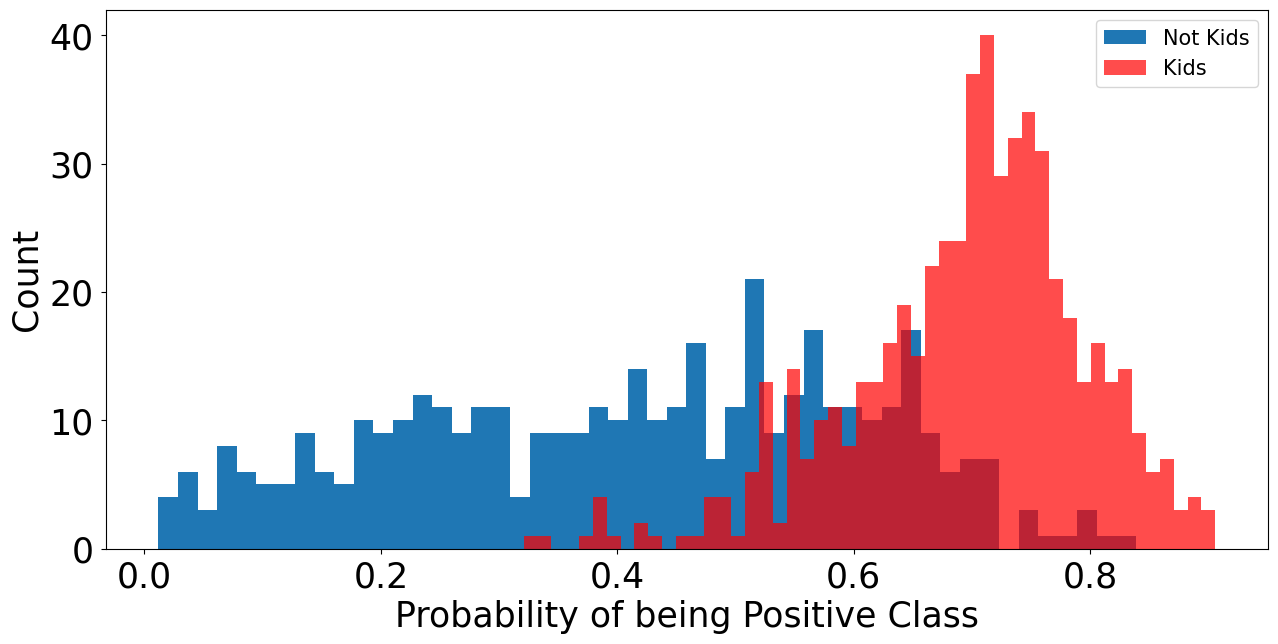

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report

print("Training Logistic Regression...")
lr = LogisticRegression(max_iter=30)


FOLDS = 5
test = cross_validate(lr, X_train, y_train, cv=FOLDS, return_estimator=True)
lr = (test["estimator"][FOLDS-1])

# lr.fit(X_train, y_train)

# Predict and evaluate on training data
y_pred_train_lr = lr.predict(X_train)
y_proba_train_lr = lr.predict_proba(X_train)[:,1]
create_graphics(y_train, y_pred_train_lr, y_proba_train_lr, "logistic_regression_train")

# Predict and evaluate on test data
y_pred_test_lr = lr.predict(X_test)
y_proba_test_lr = lr.predict_proba(X_test)[:,1]
create_graphics(y_test, y_pred_test_lr, y_proba_test_lr, "logistic_regression_test")




* c. Random Forest
Non linear ensemble model. Handles mixed feature types and shows feature importance

Training Random Forest...
              precision    recall  f1-score   support

           0       0.98      0.69      0.81       976
           1       0.82      0.99      0.89      1328

    accuracy                           0.86      2304
   macro avg       0.90      0.84      0.85      2304
weighted avg       0.88      0.86      0.86      2304

              precision    recall  f1-score   support

           0       0.96      0.64      0.77       419
           1       0.79      0.98      0.87       569

    accuracy                           0.84       988
   macro avg       0.87      0.81      0.82       988
weighted avg       0.86      0.84      0.83       988



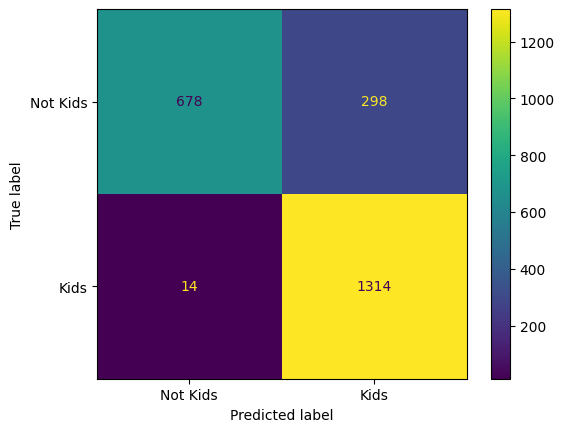

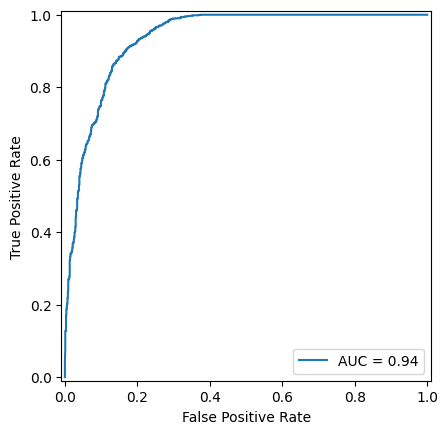

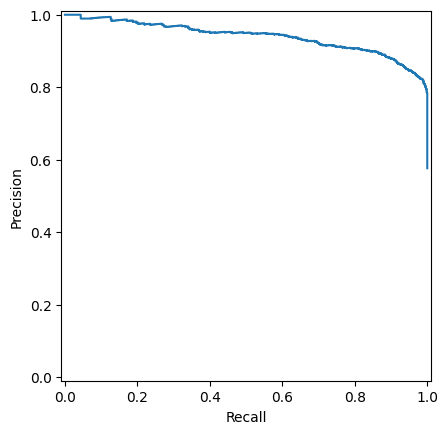

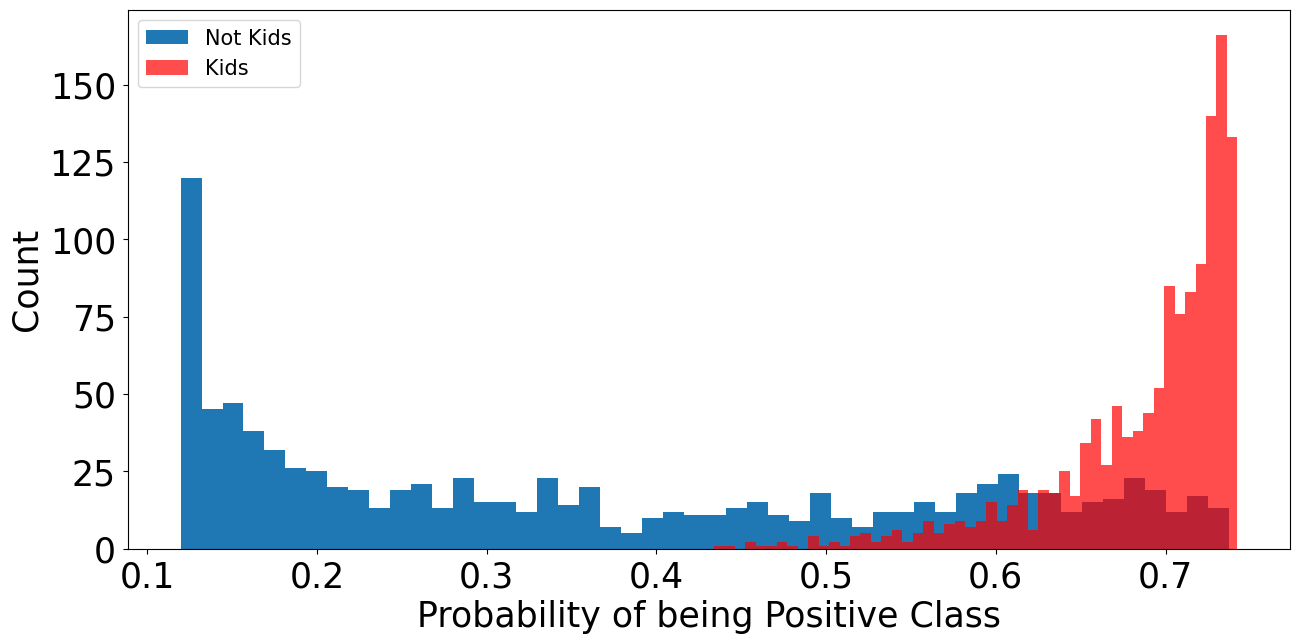

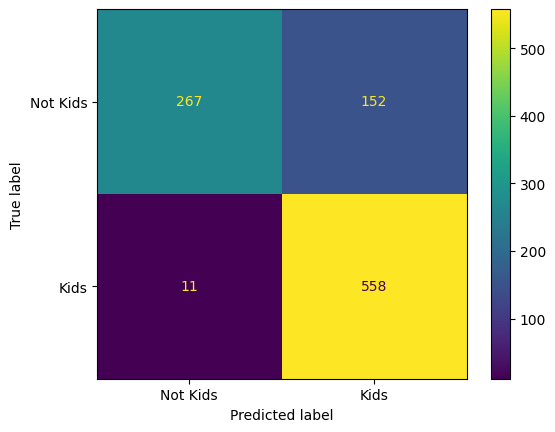

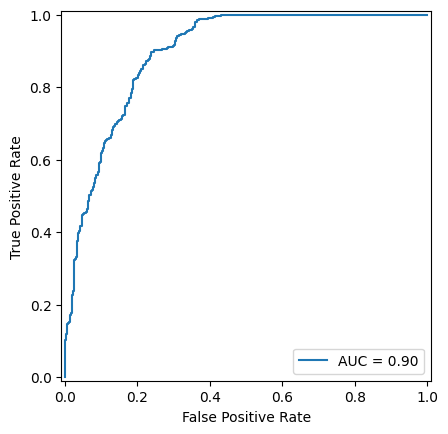

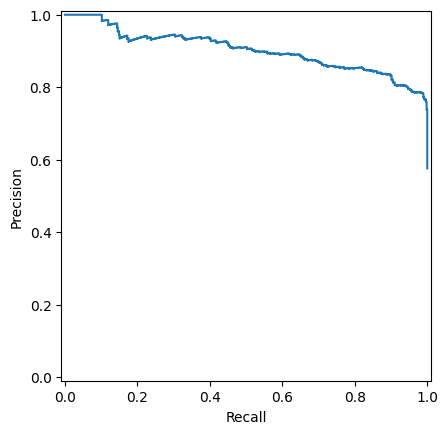

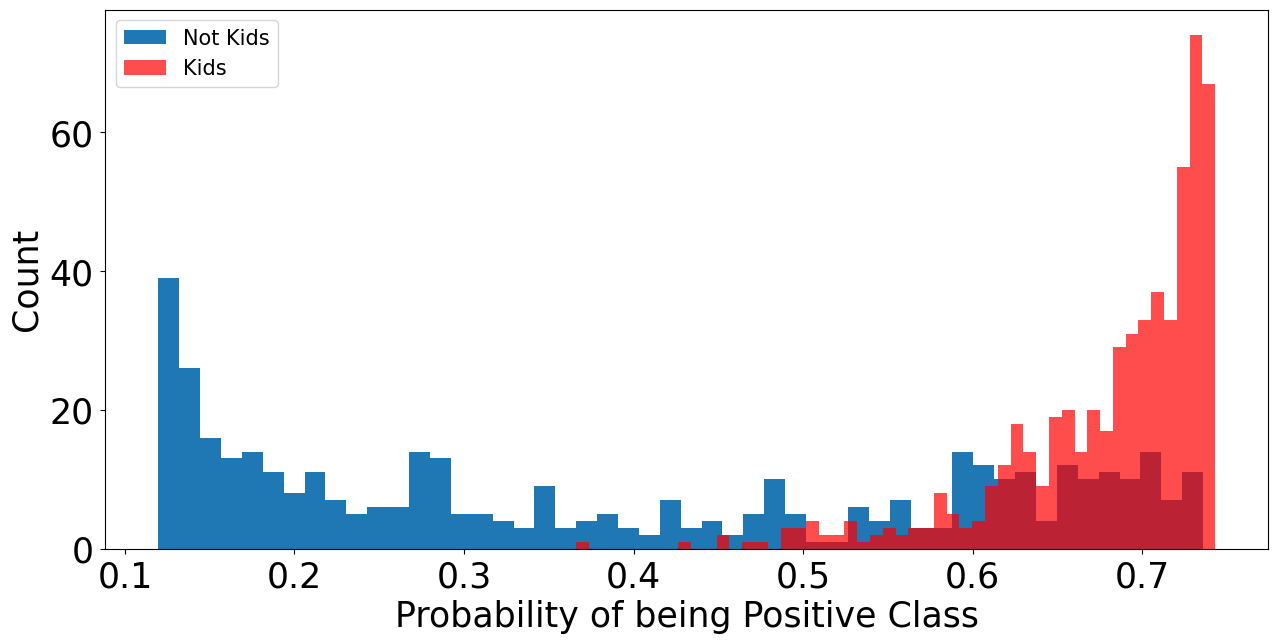

In [ ]:
from sklearn.ensemble import RandomForestClassifier

print("Training Random Forest...")
rf = RandomForestClassifier(n_estimators=100, random_state=42, min_samples_split=500, min_samples_leaf=5)
FOLDS = 5
tmp = cross_validate(rf, X_train, y_train, cv=FOLDS, return_estimator=True)
rf = (test["estimator"][FOLDS-1])


# Predict and evaluate on training data
y_pred_train = rf.predict(X_train)
y_proba_train = rf.predict_proba(X_train)[:,1]
create_graphics(y_train, y_pred_train, y_proba_train, "random_forest_train")

# Predict and evaluate on test data
y_pred_rf = rf.predict(X_test)
y_proba_test = rf.predict_proba(X_test)[:,1]
create_graphics(y_test, y_pred_rf, y_proba_test, "random_forest_test")

* d. Support Vector Machine (LinearSVC)
Effective for high-dimensional sparse data.sparse data.

Training SVM...
              precision    recall  f1-score   support

           0       0.91      0.86      0.89       976
           1       0.90      0.94      0.92      1328

    accuracy                           0.91      2304
   macro avg       0.91      0.90      0.90      2304
weighted avg       0.91      0.91      0.91      2304

              precision    recall  f1-score   support

           0       0.83      0.73      0.77       419
           1       0.81      0.89      0.85       569

    accuracy                           0.82       988
   macro avg       0.82      0.81      0.81       988
weighted avg       0.82      0.82      0.82       988



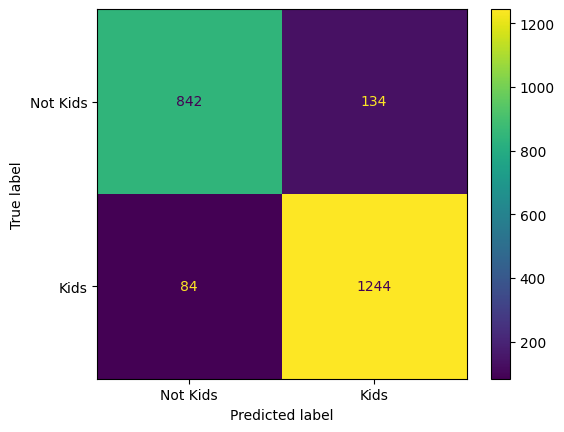

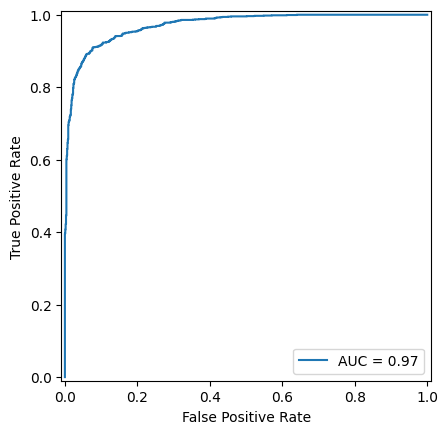

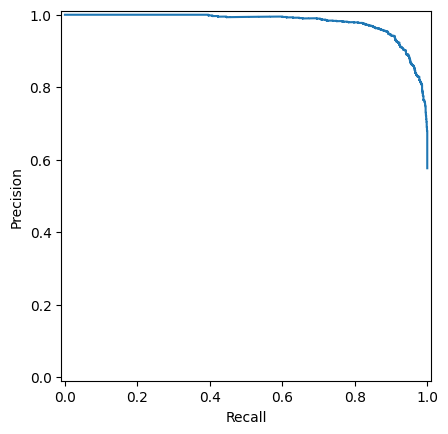

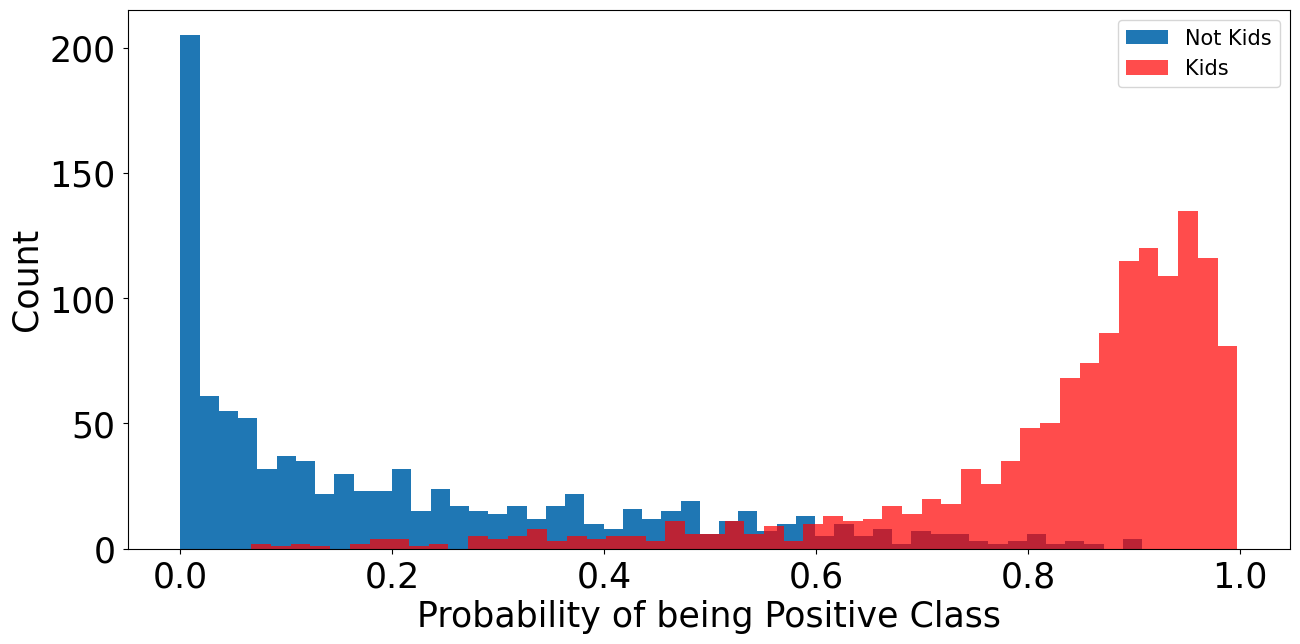

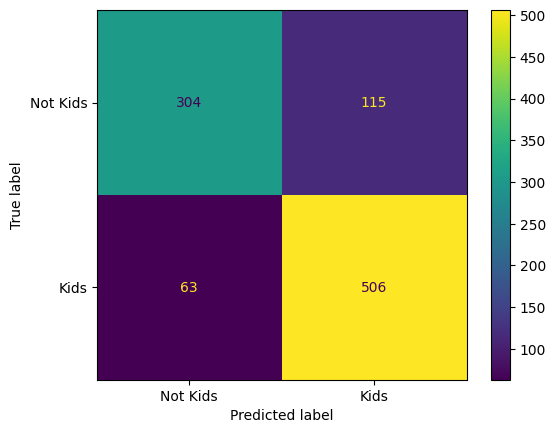

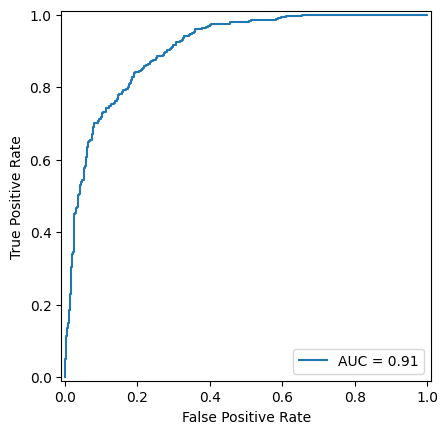

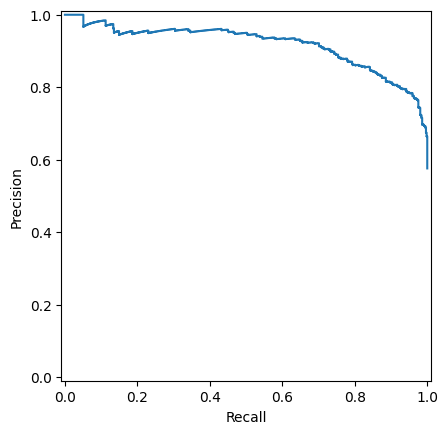

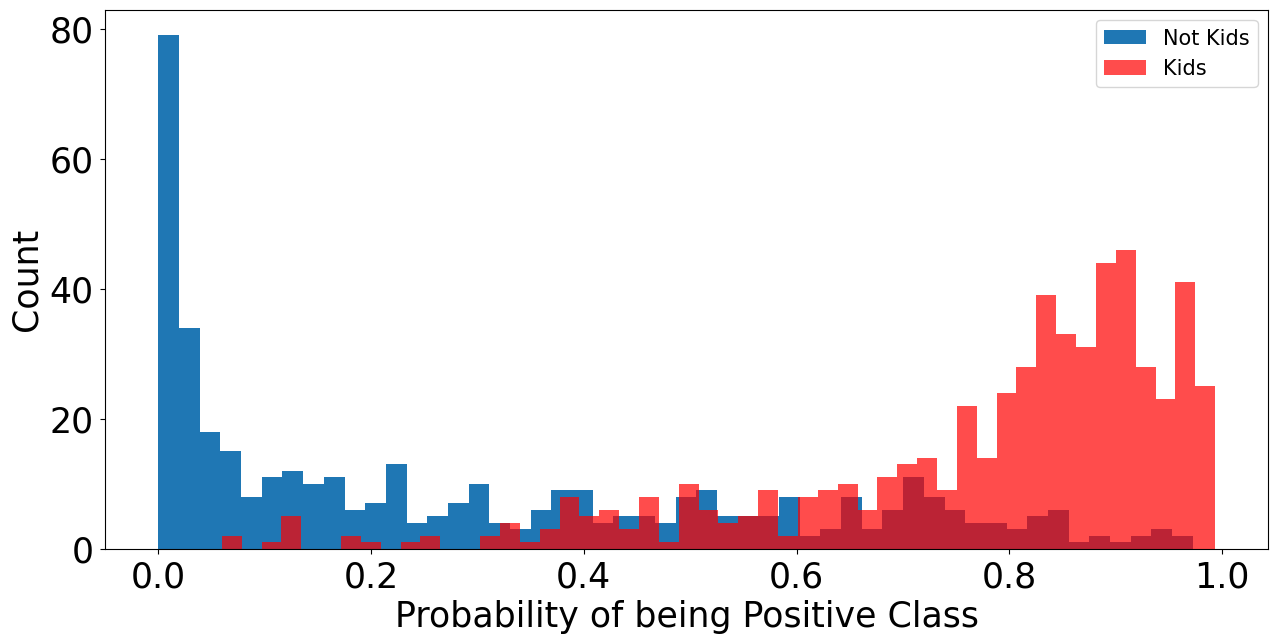

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

print("Training SVM...")
# CalibratedClassifierCV is needed to get the probabilities
svm = CalibratedClassifierCV(LinearSVC(max_iter=50, C=0.1), method='sigmoid', cv=5)
FOLDS = 5
test = cross_validate(svm, X_train, y_train, cv=FOLDS, return_estimator=True)
svm = (test["estimator"][FOLDS-1])


# Predict and evaluate on training data
y_pred_train = svm.predict(X_train)
y_proba_train = svm.predict_proba(X_train)[:,1]
create_graphics(y_train, y_pred_train, y_proba_train, "SVM_train")

# Predict and evaluate on test data
y_pred_svm = svm.predict(X_test)
y_pred_proba = svm.predict_proba(X_test)[:,1]
create_graphics(y_test, y_pred_svm,y_pred_proba, "SVM_test")





* e. Gradient Boosting (XGBoost)
Best for complex relationships.

Training XGBoost...
              precision    recall  f1-score   support

           0       0.98      0.69      0.81       976
           1       0.82      0.99      0.89      1328

    accuracy                           0.86      2304
   macro avg       0.90      0.84      0.85      2304
weighted avg       0.88      0.86      0.86      2304

              precision    recall  f1-score   support

           0       0.96      0.64      0.77       419
           1       0.79      0.98      0.87       569

    accuracy                           0.84       988
   macro avg       0.87      0.81      0.82       988
weighted avg       0.86      0.84      0.83       988



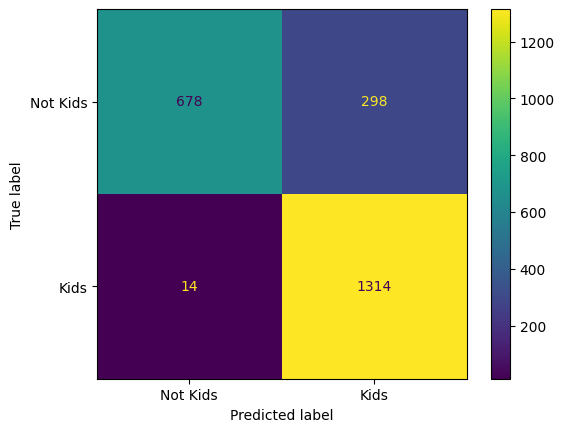

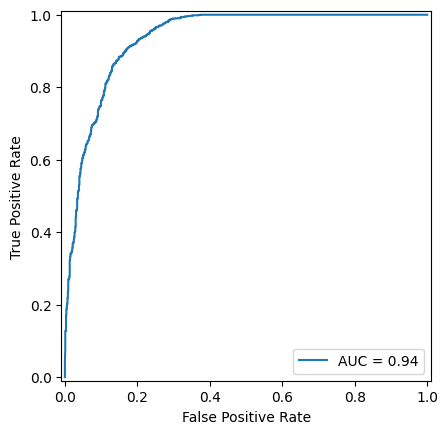

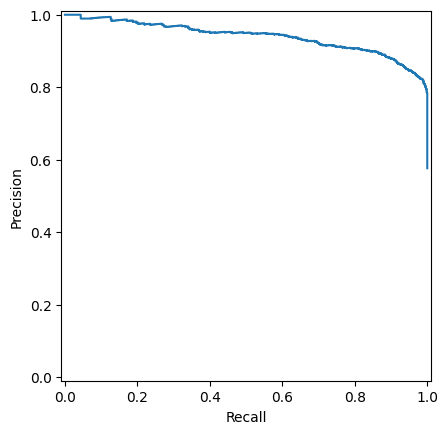

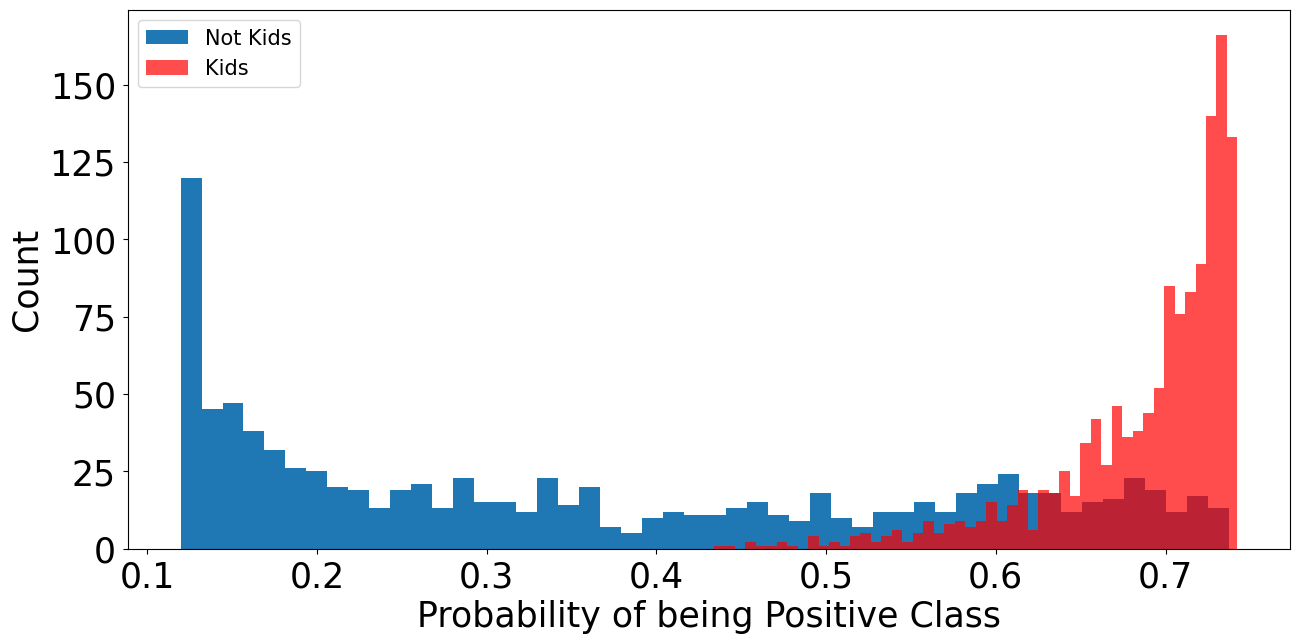

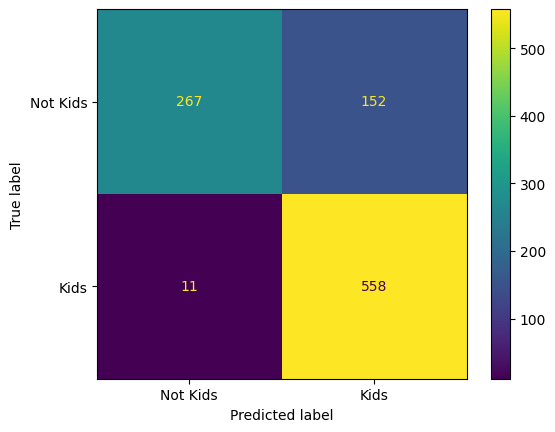

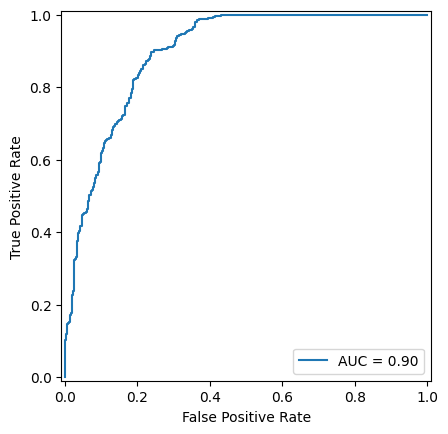

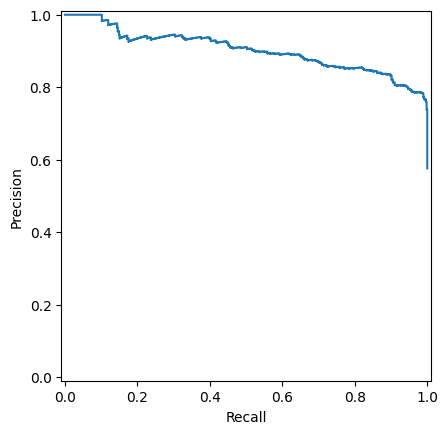

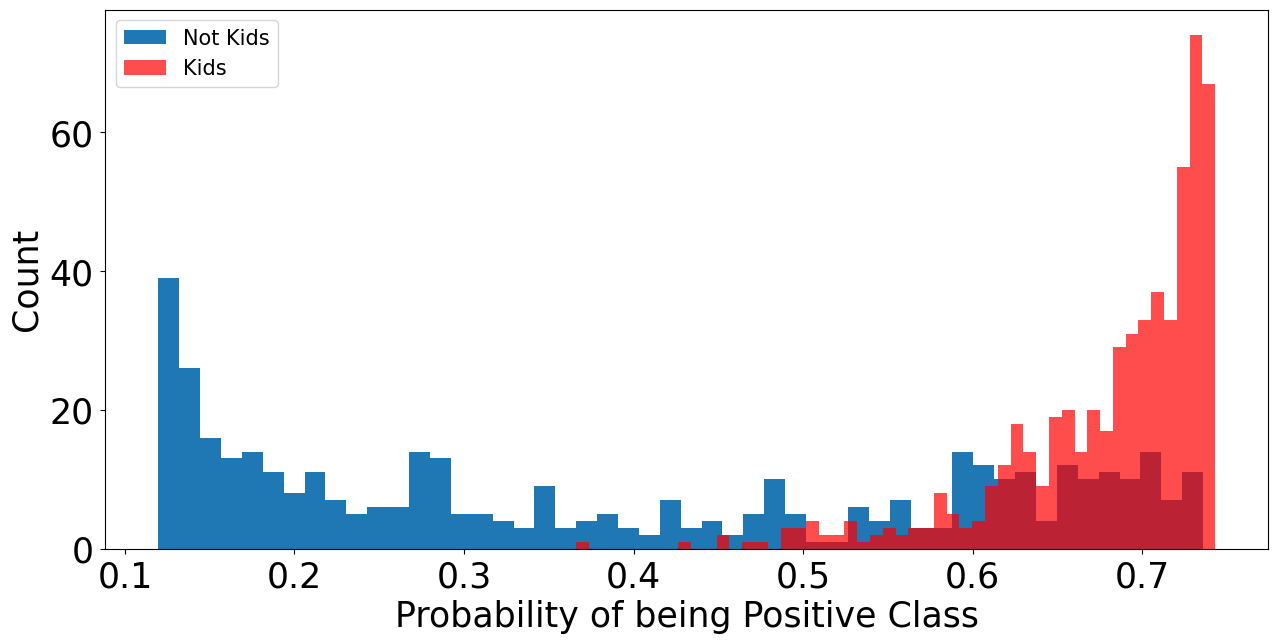

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report

print("Training XGBoost...")

# Fit the XGBoost model
xgb_model = xgb.XGBClassifier(eval_metric='logloss', subsample=0.5, colsample_bytree=0.5 , num_parallel_tree=3, eta=0.01)
FOLDS = 5
test = cross_validate(xgb_model, X_train, y_train, cv=FOLDS, return_estimator=True)
xgb_model = (test["estimator"][FOLDS-1])

# Predict and evaluate on training data
y_pred_train_xgb = xgb_model.predict(X_train)
y_proba_train_xgb = xgb_model.predict_proba(X_train)[:,1]
create_graphics(y_train, y_pred_train_xgb, y_proba_train_xgb, "XGBoost_train")

# Predict and evaluate on test data
y_pred_test_xgb = xgb_model.predict(X_test)
y_proba_test_xgb = xgb_model.predict_proba(X_test)[:,1]
create_graphics(y_test, y_pred_test_xgb, y_proba_test_xgb, "XGBoost_test")


f. Multilayer Perceptrons

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 16)             │       160,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,161 (625.63 KB)

 Trainable params: 160,161 (625.63 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------

Starting MLP Training...
Epoch 1/3
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5828 - loss: 0.6875 - val_accuracy: 0.5962 - val_loss: 0.6614
Epoch 2/3
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6374 - loss: 0.6436 - val_accuracy: 0.7277 - val_loss: 0.6114
Epoch 3/3
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7901 - loss: 0.5715 - val_accuracy: 0.8077 - val_loss: 0.5504

MLP Training Complete. Evaluating...
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

         0.0       0.99      0.77      0.87       976
         1.0       0.86      0.99      0.92      1328

    accuracy                           0.90      2304
   macro avg       0.92      0.88      0.89      2304
weighted avg       0.91      0.90      0.90      2304

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

         0.0       0.95      0.58      0.72       419
 

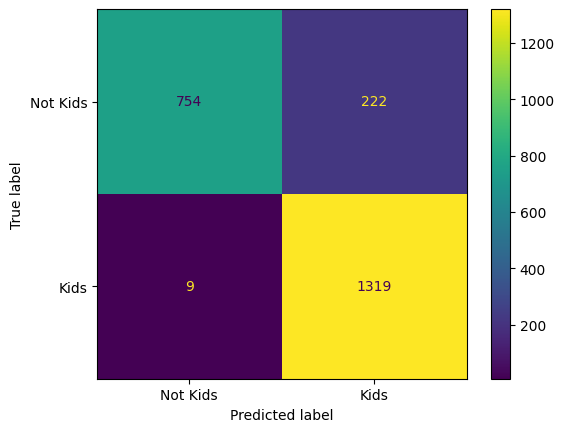

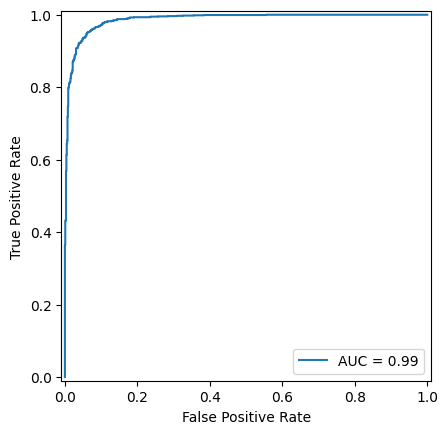

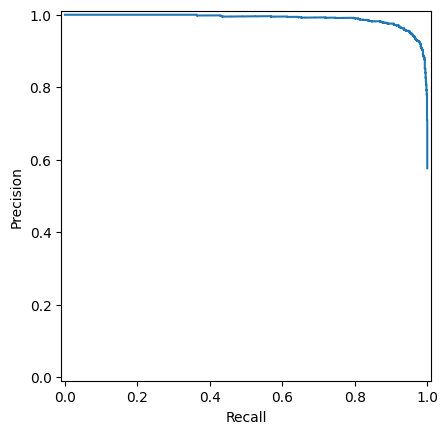

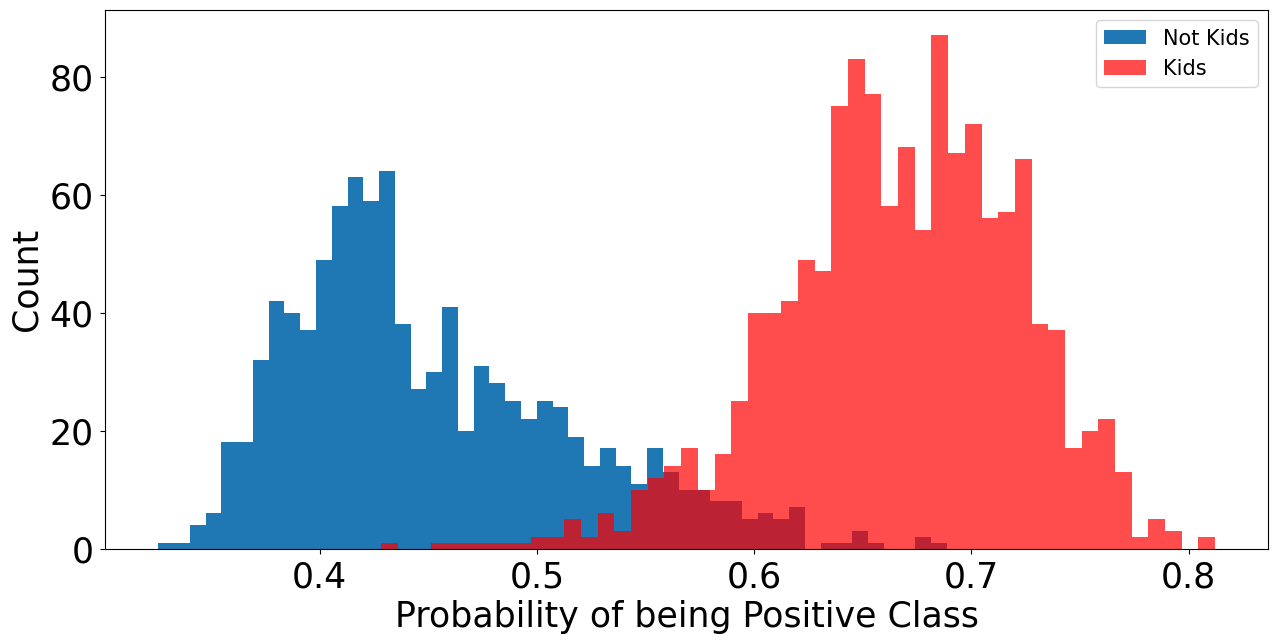

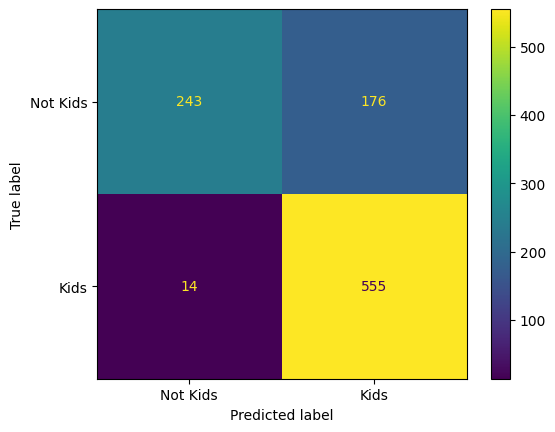

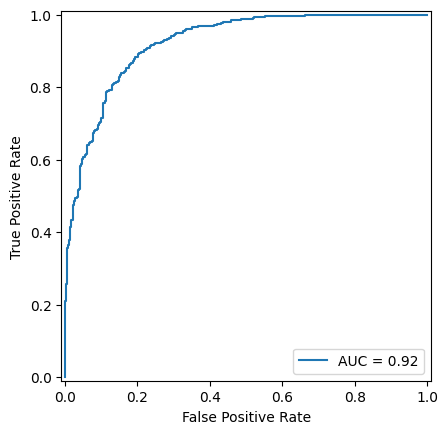

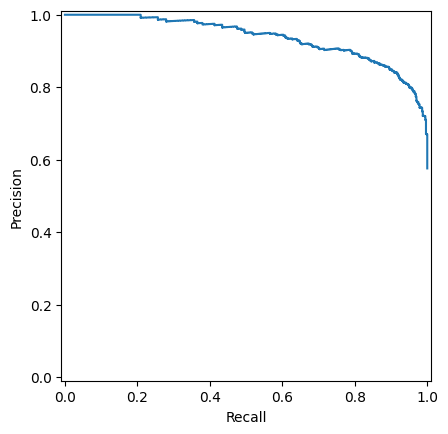

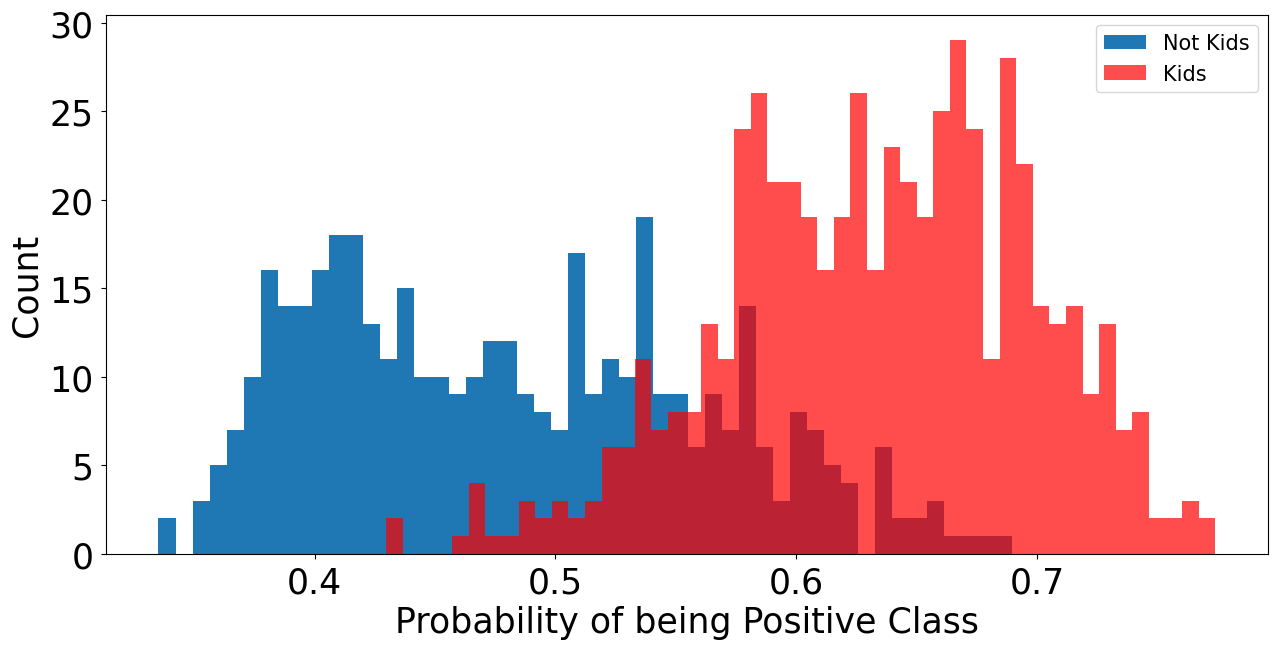

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, Dropout, TextVectorization, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report

X_train_dense = X_train.toarray().astype(np.float32)
X_test_dense = X_test.toarray().astype(np.float32)
Y_train_dense = y_train.values.astype(np.float32)
Y_test_dense = y_test.values.astype(np.float32)

model_mlp = Sequential()

input_dim = X_train.shape[1]
# 1. Input Layer - takes the dense TF-IDF vector
model_mlp.add(tf.keras.Input(shape=(input_dim,)))

# 2. Dense Layers (The MLP part) - Starting directly with dense layers
model_mlp.add(Dense(16, activation='relu'))
model_mlp.add(Dropout(0.3))
model_mlp.add(Dense(8, activation='relu'))

    # 3. Output Layer
model_mlp.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Summary
model_mlp.summary()
print("------------------------------------------\n")


# --- 4. Training and Evaluation (Matching XGBoost Format) ---

print(f"Starting MLP Training...")

# Train the model using the dense NumPy arrays
# No need for tf.data.Dataset string handling anymore
history = model_mlp.fit(
    X_train_dense,
    Y_train_dense,
    epochs=3,
    batch_size=64,
    validation_data=(X_test_dense, Y_test_dense),
    verbose=1
)

print(f"\nMLP Training Complete. Evaluating...")


# --- 4a. Predict and evaluate on Training Data ---
y_pred_proba_train = model_mlp.predict(X_train_dense)
y_pred_mlp_train = (y_pred_proba_train > 0.5).astype("int32").flatten()
Y_train_int = Y_train_dense.astype("int32")
create_graphics(Y_train_dense, y_pred_mlp_train, y_pred_proba_train, "MLP_train")

# Predict using the dense training features
# y_pred_mlp_train = (model_mlp.predict(X_train_dense) > 0.5).astype("int32")
# Y_train_int = Y_train_dense.astype("int32")


# --- 4b. Predict and evaluate on Test Data ---

y_pred_proba_test = model_mlp.predict(X_test_dense)
y_pred_mlp_test = (y_pred_proba_test > 0.5).astype("int32").flatten()
Y_test_int = Y_test_dense.astype("int32")
create_graphics(Y_test_dense, y_pred_mlp_test, y_pred_proba_test, "MLP_test")


5. Model Comparison Table: Compare accruacy, precision, and recall for all models

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pandas as pd

results = {
    'LSTM Train': [
        accuracy_score(y_train_text, y_pred_lstm_train),
        precision_score(y_train_text, y_pred_lstm_train),
        recall_score(y_train_text, y_pred_lstm_train)
    ],
    'LSTM Test': [
        accuracy_score(y_test_text, y_pred_lstm_test),
        precision_score(y_test_text, y_pred_lstm_test),
        recall_score(y_test_text, y_pred_lstm_test)
    ],
    'Logistic Regression Train': [
        accuracy_score(y_train, lr.predict(X_train)),
        precision_score(y_train, lr.predict(X_train)),
        recall_score(y_train, lr.predict(X_train))
    ],
    'Logistic Regression Test': [
        accuracy_score(y_test, lr.predict(X_test)),
        precision_score(y_test, lr.predict(X_test)),
        recall_score(y_test, lr.predict(X_test))
    ],
    'Random Forest Train': [
        accuracy_score(y_train, rf.predict(X_train)),
        precision_score(y_train, rf.predict(X_train)),
        recall_score(y_train, rf.predict(X_train))
    ],
    'Random Forest Test': [
        accuracy_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_rf)
    ],
    'SVM Train': [
        accuracy_score(y_train, svm.predict(X_train)),
        precision_score(y_train, svm.predict(X_train)),
        recall_score(y_train, svm.predict(X_train))
    ],
    'SVM Test': [
        accuracy_score(y_test, y_pred_svm),
        precision_score(y_test, y_pred_svm),
        recall_score(y_test, y_pred_svm)
    ],
    'XGBoost Train': [
        accuracy_score(y_train, xgb_model.predict(X_train)),
        precision_score(y_train, xgb_model.predict(X_train)),
        recall_score(y_train, xgb_model.predict(X_train))
    ],
    'XGBoost Test': [
        accuracy_score(y_test, y_pred_test_xgb),
        precision_score(y_test, y_pred_test_xgb),
        recall_score(y_test, y_pred_test_xgb)
    ],
    'MLP (TF-IDF) Train': [
        accuracy_score(y_train, y_pred_mlp_train),
        precision_score(y_train, y_pred_mlp_train),
        recall_score(y_train, y_pred_mlp_train)
    ],
    'MLP (TF-IDF) Test': [
        accuracy_score(y_test, y_pred_mlp_test),
        precision_score(y_test, y_pred_mlp_test),
        recall_score(y_test, y_pred_mlp_test)
    ]
}

results_df = pd.DataFrame(results, index=['Accuracy', 'Precision', 'Recall'])
print(results_df)


           LSTM Train  LSTM Test  Logistic Regression Train  \
Accuracy     0.818458   0.761760                   0.889323   
Precision    0.814277   0.775309                   0.852728   
Recall       0.887278   0.826316                   0.976657   

           Logistic Regression Test  Random Forest Train  Random Forest Test  \
Accuracy                   0.812753             0.864583            0.835020   
Precision                  0.769663             0.815136            0.785915   
Recall                     0.963093             0.989458            0.980668   

           SVM Train  SVM Test  XGBoost Train  XGBoost Test  \
Accuracy    0.905382  0.819838       0.864583      0.835020   
Precision   0.902758  0.814815       0.815136      0.785915   
Recall      0.936747  0.889279       0.989458      0.980668   

           MLP (TF-IDF) Train  MLP (TF-IDF) Test  
Accuracy             0.899740           0.807692  
Precision            0.855938           0.759234  
Recall              

--- Summary Metrics DataFrame ---
           LSTM Train  LSTM Test  Logistic Regression Train  \
Accuracy     0.818458   0.761760                   0.889323   
Precision    0.814277   0.775309                   0.852728   
Recall       0.887278   0.826316                   0.976657   

           Logistic Regression Test  Random Forest Train  Random Forest Test  \
Accuracy                   0.812753             0.864583            0.835020   
Precision                  0.769663             0.815136            0.785915   
Recall                     0.963093             0.989458            0.980668   

           SVM Train  SVM Test  XGBoost Train  XGBoost Test  \
Accuracy    0.905382  0.819838       0.864583      0.835020   
Precision   0.902758  0.814815       0.815136      0.785915   
Recall      0.936747  0.889279       0.989458      0.980668   

           MLP (TF-IDF) Train  MLP (TF-IDF) Test  
Accuracy             0.899740           0.807692  
Precision            0.855938        

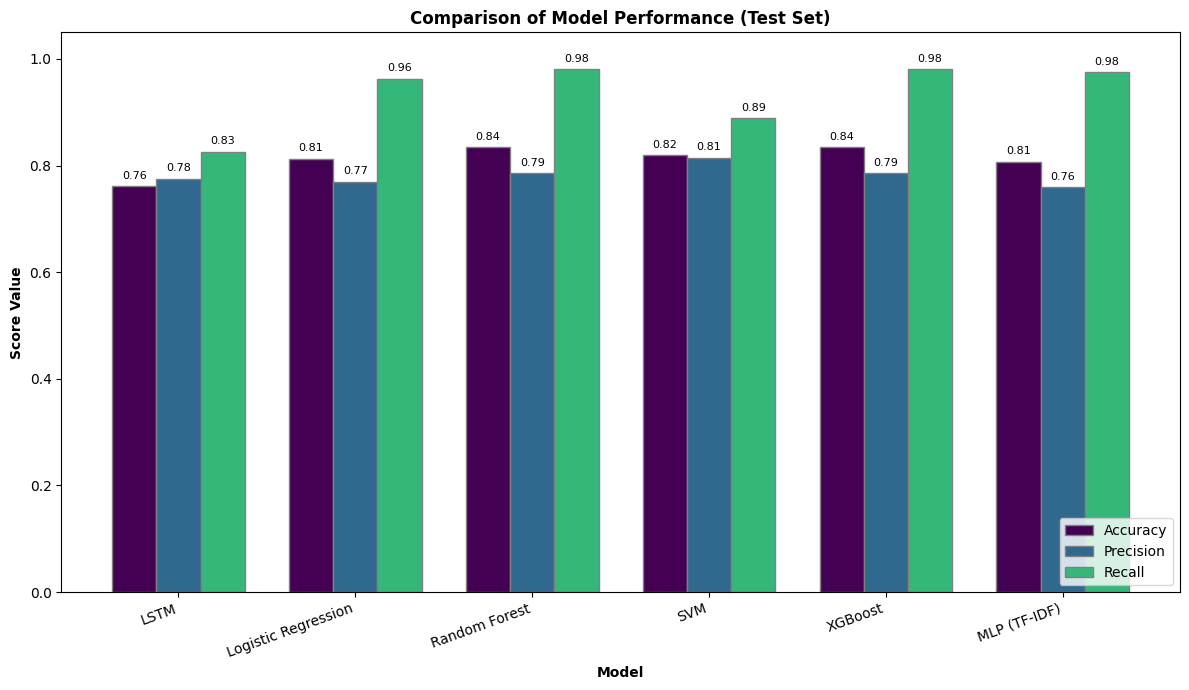

In [ ]:
import matplotlib.pyplot as plt

results_df = pd.DataFrame(results, index=['Accuracy', 'Precision', 'Recall'])
print("--- Summary Metrics DataFrame ---")
print(results_df)

# ==============================================================================
# 2. Plotting Function for Summary Metrics
# ==============================================================================

def plot_summary_metrics(results_df):
    """Generates a grouped bar chart comparing test set performance across models."""

    # Filter the DataFrame to only include Test Set results for a clean comparison
    test_cols = [col for col in results_df.columns if 'Test' in col]
    test_results_df = results_df[test_cols]

    # Rename columns for cleaner labels (e.g., 'Logistic Regression Test' -> 'Logistic Regression')
    test_results_df.columns = [col.replace(' Test', '') for col in test_results_df.columns]

    # Transpose for plotting: rows become models, columns become metrics
    plot_df = test_results_df.T

    # Define plot parameters
    metrics = plot_df.columns.tolist()
    models = plot_df.index.tolist()
    n_models = len(models)
    n_metrics = len(metrics)

    # Set bar width and positions
    bar_width = 0.25
    r = np.arange(n_models)

    plt.figure(figsize=(12, 7))

    # Create grouped bar plots
    for i, metric in enumerate(metrics):
        # Calculate position for each group of bars
        offset = i * bar_width
        bars = plt.bar(r + offset, plot_df[metric], color=plt.cm.viridis(i/n_metrics),
                       width=bar_width, edgecolor='grey', label=metric)

        # Add the score values on top of the bars
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}',
                     ha='center', va='bottom', fontsize=8)

    # Add labels, title, and customize layout
    plt.xlabel('Model', fontweight='bold')
    plt.ylabel('Score Value', fontweight='bold')
    plt.xticks(r + bar_width, models, rotation=20, ha='right')
    plt.ylim(0, 1.05)
    plt.title('Comparison of Model Performance (Test Set)', fontweight='bold')
    plt.legend(loc='lower right')
    plt.tight_layout()

    plt.show()

# --- 3. Run the plotting function ---
plot_summary_metrics(results_df)